Daniel Shalam - 205745052

Noy Boutboul - 206282691

# Deep Q-Network for Atari Breakout.

In this assignment you are required to implement a Deep Q-Network agent, for the Atari game Breakout. 

You need to submit your code, along with a plot of the rewards during training, and a video of an episode with the trained agent. 


__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for PyTorch, but you'll find it easy to adapt it to almost any Python-based deep learning framework.

In [1]:
# for i in range(0,20):
#   !pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org autorom==0.5.5
#   !AutoROM --accept-license

# !wget http://www.atarimania.com/roms/Roms.rar
# !unrar x Roms.rar -Y
# !pip install gym[atari]==0.15.3
# !pip uninstall ale-py -Y
# !pip install ale-py==0.7.4
# !ale-import-roms ./ROMS/Y
# !pip install jedi==0.10
# !pip install pyglet==1.5.27
# !pip install pyvirtualdisplay

!pip install jedi==0.10


!pip install stable-baselines3[extra] ale-py==0.7.4
!pip install pyglet==1.5.27
!pip install pyvirtualdisplay

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 KB 5.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.8/171.8 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 47.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 KB 1.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 13.4 MB/s eta 0:00:00
  Using cached libtorrent-2.0.7-cp38-cp38-manylinux_2_12_x86_64.m

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import random
import numpy as np
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions
from torchvision import models
from torchsummary import summary
from google.colab import files

# if gpu is to be used
if torch.cuda.is_available():
  print("running with GPU")
else:
  print("No GPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !apt-get -qq install -y xvfb
    os.environ['DISPLAY'] = ':1'

display = Display(visible=0, size=(400, 300))
display.start()


running with GPU
Selecting previously unselected package xvfb.
(Reading database ... 128126 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.20.13-1ubuntu1~20.04.6_amd64.deb ...
Unpacking xvfb (2:1.20.13-1ubuntu1~20.04.6) ...
Setting up xvfb (2:1.20.13-1ubuntu1~20.04.6) ...
Processing triggers for man-db (2.9.1-1) ...


## Breakout

This is an environment emulating the Atari game *Breakout*. The goal is to break all the bricks in the wall without letting the ball touch the floor. You have 5 lives and get points more points for higher brick than for the lower ones. 

The observation is an image with dimensions (210, 160, 3).

There are 4 actions defined as NOOP, FIRE, LEFT and RIGHT.

See full description [here](https://www.gymlibrary.dev/environments/atari/Breakout).



In [3]:
ENV_NAME = "BreakoutNoFrameskip-v4"

observation dim (210, 160, 3) number of actions 4


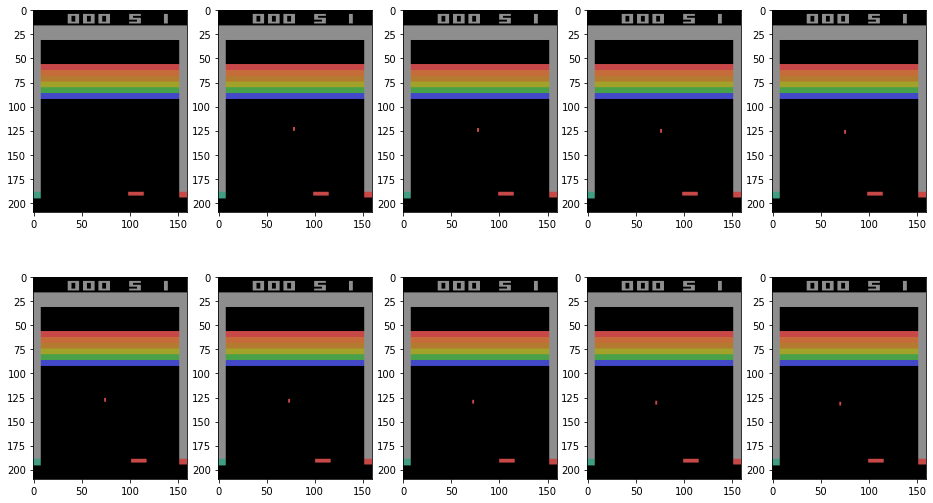

In [174]:
env = gym.make(ENV_NAME)
obs = env.reset()

n_actions = env.action_space.n
obs_dim = obs.shape
print("observation dim", obs_dim, "number of actions", n_actions)


n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        #ax.imshow(obs)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

## Wrappers

In order to make the environment more suitable for RL training, we make the following updates to the environment, using environment wrappers:
1. Preprocess the images to contain only the relevant part of the image, converted to grayscale. The raw images are large and we can do with 64x64 images.
2. Concatenate the 4 previous images (in order to capture dynamics)
3. Start the fire action automatically when starting the episode
4. Repeat the same action for 4 time steps
5. Output the maximum values of the last 2 frames per pixel (in order to prevent blinking)
6. Ouput a "done" signal every time a life is reduced but only reset the environment when all lives are gone
7. Bin the rewards to the values {-1, 0, 1}




In [175]:
from gym.core import Wrapper
from gym.spaces.box import Box
from gym.core import ObservationWrapper
from gym.spaces import Box
import cv2

class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def observation(self, img):
        """what happens to each observation"""

        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type
        img = img[34:-16, 8:-8, :]
        img = cv2.resize(img, self.img_size[1:])
        img = (img*np.array([[[0.8, .1, .1]]])).sum(-1, keepdims=True)  # grayscale with more weight for red (accelerates training)
        img = img.astype('float32') / 255.
        return img.transpose((2, 0, 1))

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros(
            (2,) + env.observation_space.shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

def PrimaryAtariWrap(env, clip_rewards=True):
    assert 'NoFrameskip' in env.spec.id

    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = EpisodicLifeEnv(env)

    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.
    env = FireResetEnv(env)

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = ClipRewardEnv(env)

    # This wrapper preprocesses observations
    env = PreprocessAtariObs(env)
    return env

class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        elif dim_order == 'pytorch':
            n_channels, height, width = env.observation_space.shape
            obs_shape = [n_channels * n_frames, height, width]
        else:
            raise ValueError(
                'dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')

    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer

    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info

    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:, :, :-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate(
            [img, cropped_framebuffer], axis=axis)
        

def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME)  # create raw env
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape

In [50]:
# for i in range(100,200):
#   env = make_env(seed = i)
#   env.reset()
#   agent = DQNAgent(n_actions)
#   mean_reward = evaluate(env, agent, greedy=True, n_games=5)
#   print("seed: ", i, " | mean_reward: ", mean_reward)

seed:  100  | mean_reward:  15.6
seed:  101  | mean_reward:  15.6
seed:  102  | mean_reward:  15.6
seed:  103  | mean_reward:  15.6
seed:  104  | mean_reward:  15.6
seed:  105  | mean_reward:  15.6
seed:  106  | mean_reward:  15.6
seed:  107  | mean_reward:  15.6
seed:  108  | mean_reward:  15.6
seed:  109  | mean_reward:  15.6
seed:  110  | mean_reward:  15.6
seed:  111  | mean_reward:  15.6
seed:  112  | mean_reward:  15.6
seed:  113  | mean_reward:  15.6
seed:  114  | mean_reward:  15.6
seed:  115  | mean_reward:  15.6
seed:  116  | mean_reward:  15.6
seed:  117  | mean_reward:  15.6


KeyboardInterrupt: ignored

## Check observations under wrappers

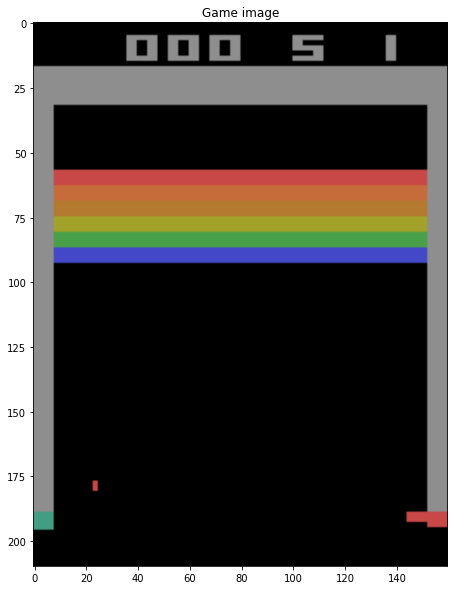

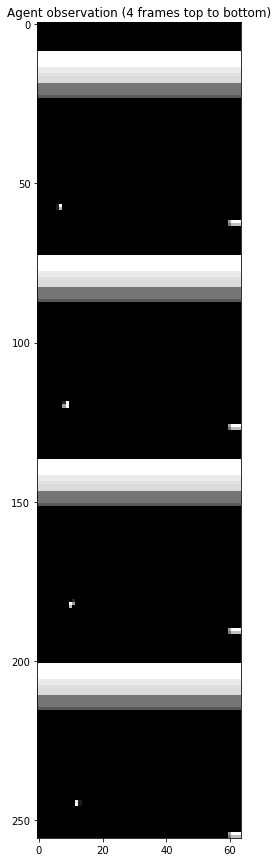

In [8]:
for _ in range(12):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(obs.reshape([-1, state_shape[2]]), cmap='gray')
plt.show()

# Replay Buffer

In [9]:
# Defining the transition as a tuple.
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# Defining the replay memoery class
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    # add a sample to memory
    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    # random sample from memory
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN model

In [10]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.input_dim = input_dim
        channels, _, _ = input_dim
        conv1 = nn.Conv2d(channels, 32, kernel_size=8, stride=4, padding=2)
        conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        # 3 conv layers, all with relu activations, first one with maxpool
        self.l1 = nn.Sequential(
            conv1,
            nn.ReLU(),
            conv2,
            nn.ReLU(),
            conv3,
            nn.ReLU()
        )
        
        # Calculate output dimensions for linear layer
        conv_output_size = self.conv_output_dim()
        lin1_output_size = 512


        fc1 = nn.Linear(conv_output_size, lin1_output_size)
        fc2 = nn.Linear(lin1_output_size, output_dim)
        fc2 = nn.Linear(lin1_output_size, output_dim)
     

        # Two fully connected layers with one relu activation
        self.l2 = nn.Sequential(
            fc1,
            nn.ReLU(),
            fc2,
        )

    # Calulates output dimension of conv layers
    def conv_output_dim(self):
        x = torch.zeros(1, *self.input_dim)
        x = self.l1(x)
        return int(np.prod(x.shape))

    # Performs forward pass through the network, returns action values
    def forward(self, x):
        x = self.l1(x)
        x = x.view(x.shape[0], -1)
        actions = self.l2(x)

        return actions


obs, _, _, _ = env.step(env.action_space.sample())  
env.reset()
print(obs.shape)
print(n_actions)

tmp_model = DQN(obs.shape, n_actions).cuda()
summary(tmp_model, (4,64,64))

(4, 64, 64)
4
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]           8,224
              ReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          32,832
              ReLU-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,928
              ReLU-6             [-1, 64, 8, 8]               0
            Linear-7                  [-1, 512]       2,097,664
              ReLU-8                  [-1, 512]               0
            Linear-9                    [-1, 4]           2,052
Total params: 2,177,700
Trainable params: 2,177,700
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 0.26
Params size (MB): 8.31
Estimated Total Size (MB): 8.63
-------------------------

# DQN Agent

In [248]:
class DQNAgent():
    def __init__(self, n_actions, target_net, policy_net):
        self.n_actions = n_actions
        self.target_net = target_net
        self.policy_net = policy_net

    def get_qvalues(self, states):
      states_t = torch.tensor(states, device=device)
      qvals = self.policy_net(states_t.to(torch.float32))
      return qvals.detach().cpu().numpy()
      
    def update_target_network(self):
      print("\n\n\nupdating network\n\n\n\n")
      self.target_net.load_state_dict(self.policy_net.state_dict())
      return

    def sample_actions(self, state, sample_only):
      global steps_done

      if sample_only is True:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

      sample = random.random()
      eps_threshold = EPS_END + (EPS_START - EPS_END) * \
          math.exp(-1. * steps_done / EPS_DECAY)
      steps_done += 1
      epsilon_vals.append(eps_threshold)

      if sample > eps_threshold:
          with torch.no_grad():
              return self.policy_net(state).max(1)[1].view(1, 1)
      else:
          return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


    def save_current_model(self):
      print("saving new best model!")
      curr_best_model =  self.policy_net.state_dict()
      torch.save(self.policy_net.state_dict(), 'policy_checkpoint.pth')

# Evaluate

In [265]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=20000, vis = False, restart_env = False, end_game_verbose = False):

    if restart_env is True:
      env = make_env()
    
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):

        visualize = vis
        s = env.reset()

        reward = 0
        for cnt_steps in range(t_max):

            with torch.no_grad():
              #print("before get values")
              qvalues = agent.get_qvalues([s])
              #print("after get values")
              action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0), sample_only = False)[0]
              #print(action)
            s, r, done, _ = env.step(action)

            # visualization
            if visualize is True and cnt_steps % 2 == 0:
              plt.figure(figsize=[5,5])
              plt.imshow(s.reshape([-1, state_shape[2]])[:64,:], cmap='gray')
              plt.show() 

            # if near max steps, turn on visualization
            if cnt_steps > (t_max -10):
              visualize = True

            reward += r
            if done:
              break
        if end_game_verbose is True:
          print("game reward: ", reward)
          print("final state:")
          plt.figure(figsize=[5,5])
          plt.imshow(s.reshape([-1, state_shape[2]])[:64,:], cmap='gray')
          plt.show() 

        # check if reahed max steps
        if cnt_steps > (t_max-10):
          print("WARNING: reached max steps, current reward: ", reward)

        rewards.append(reward)
    return np.mean(rewards)

# Create / Load models

In [57]:

# LOAD_PREV_MODEL loading previous checkpoint
LOAD_PREV_MODEL = False#@param ["False", "True"] {type:"raw"}
INIT = True #@param ["False", "True"] {type:"raw"}
init_thresh = 0.025

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
obs, _, _, _ = env.step(env.action_space.sample()) 
n_observations = obs.shape

target_net = DQN(n_observations, n_actions).to(device)
policy_net = DQN(n_observations, n_actions).to(device)


if LOAD_PREV_MODEL is True:
  #files.upload()
  print("LOADING MODELS")
  target_state_dict = torch.load('policy_checkpoint.pth')
  target_net.load_state_dict(target_state_dict)
  policy_net.load_state_dict(target_state_dict)


else:
  target_net.load_state_dict(policy_net.state_dict())

  # initializing weights
  if INIT:
    stop_init = False
    while not stop_init:
      # load model or create new:
      target_net = DQN(n_observations, n_actions).to(device)
      policy_net = DQN(n_observations, n_actions).to(device)
      agent = DQNAgent(n_actions, target_net=target_net, policy_net=policy_net)
      s = env.reset()
      qvalues = agent.get_qvalues([s])
      print(qvalues[0])
      if np.min(qvalues[0]) > 0 and (np.max(qvalues[0])-np.min(qvalues[0])) < init_thresh:
        stop_init = True
        print(np.max(qvalues[0])-np.min(qvalues[0]))
        print(np.max(qvalues[0]))
    policy_net.load_state_dict(target_net.state_dict())
    agent = DQNAgent(n_actions, target_net=target_net, policy_net=policy_net)
    mean_reward = evaluate(env, agent, greedy=True, n_games=2)
    print(mean_reward)

  print("NEW MODELS!")

LOADING MODELS


# Parameters and utils

In [184]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
# UPDATE_FREQUENCY after UPDATE_FREQUENCY steps, the target network gets the weights of the policy network
# UPDATE_TRAIN_POLICY_FREQUENCY update policy(train) every 4 steps

BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 0.5
EPS_END = 0.01
EPS_DECAY = 2000000
TAU = 0.0005
LR = 1e-4
UPDATE_FREQUENCY = 1000
EPISODES = 90000
RECORD_SAMPLES = 150000 # (episodes)
MEMORY_SIZE = 175000 #(samples)
LEARNING_COUNTER = 0 

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
obs, _, _, _ = env.step(env.action_space.sample())  
n_observations = obs.shape

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(MEMORY_SIZE)
# create agent
agent = DQNAgent(n_actions, target_net=target_net, policy_net=policy_net)

# data lists
curr_best_model = None
current_max_reward = 0
steps_done = 0
epsilon_vals = []
episode_durations = []
losses_epochs = []
scores_epochs = []
rewards_eval = []

def select_action(state, sample_only):
    global steps_done

    if sample_only is True:
      return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    epsilon_vals.append(eps_threshold)

    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated


def plot_loss(losses):
    plt.plot(np.arange(len(losses)), losses,color='r')
    plt.xlabel('Number of iterations')
    plt.ylabel('Loss')
    plt.title('Loss Function Plot')
    plt.show()

def plot_rewards(rewards, color):
    plt.scatter(np.arange(len(rewards)), rewards, marker='x',color=color)
    plt.xlabel('Number of iterations')
    plt.ylabel('Rewards')
    plt.title('Rewards Function Plot')
    plt.show()

def plot_epsilon(eps):
    plt.plot(np.arange(len(eps)), eps,color='k')
    plt.xlabel('Number of iterations')
    plt.ylabel('Epsilon')
    plt.title('Epsilon Function Plot')
    plt.show()


def fill_memory_buffer():
  # recording memory
  while len(memory) < RECORD_SAMPLES:
    print(len(memory))
    done = False

    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    terminated = False

    while not terminated:

        action = select_action(state, sample_only=True)
        next_state, reward, terminated, truncated,  = env.step(action.item())

        reward = torch.tensor([reward], device=device)

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)





# Training Loop

episode:  0


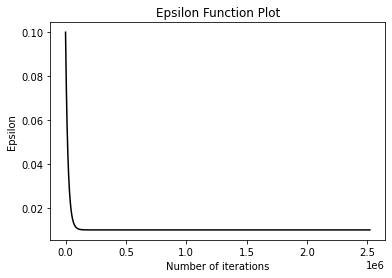

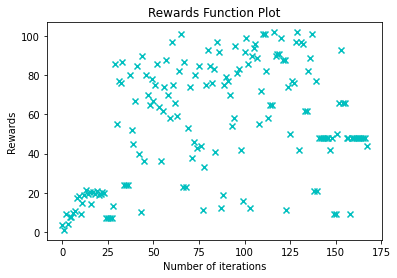

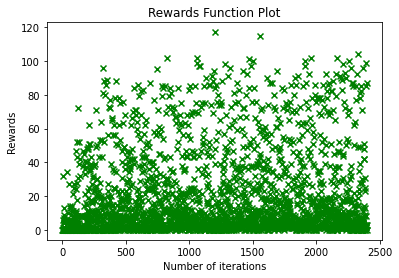

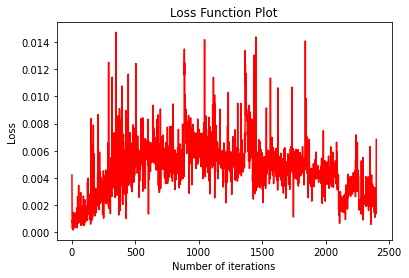

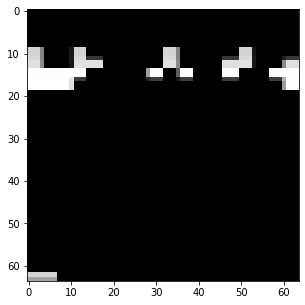

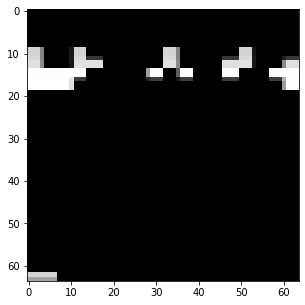

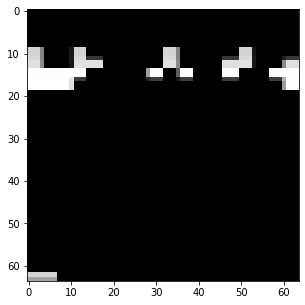

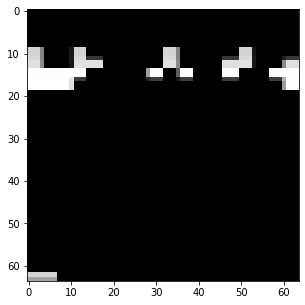

episode:  5


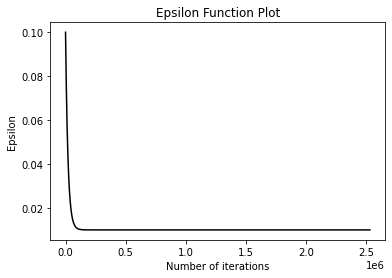

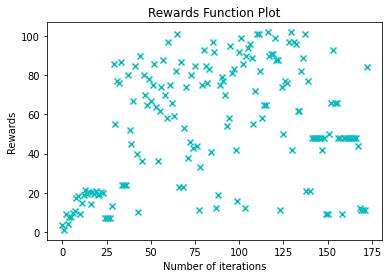

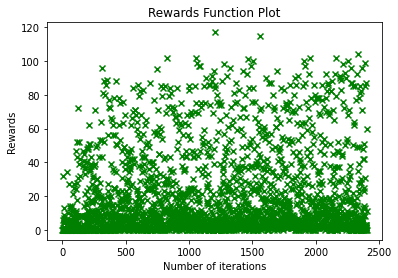

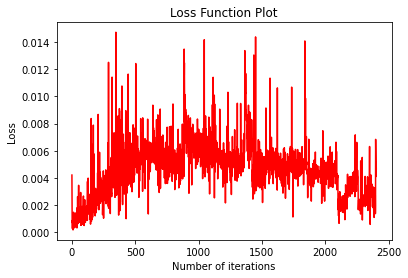

episode:  10


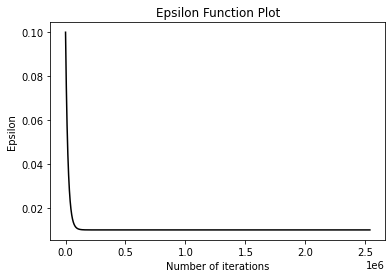

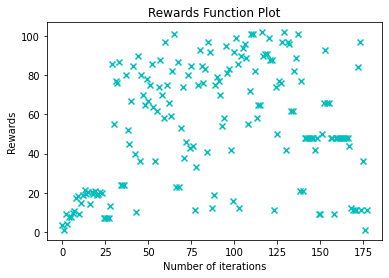

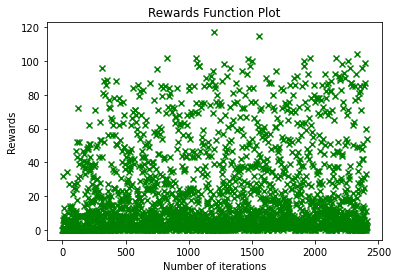

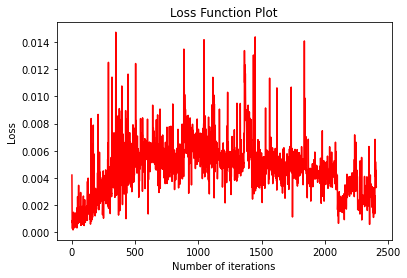

episode:  15


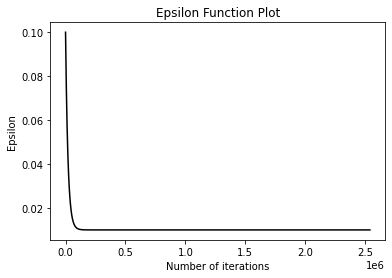

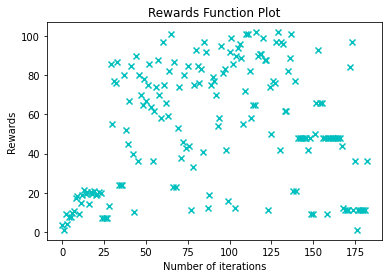

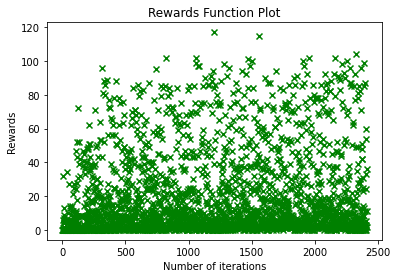

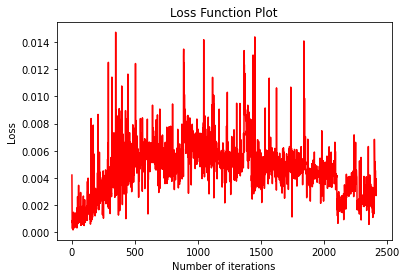

episode:  20


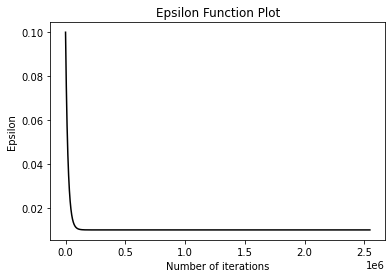

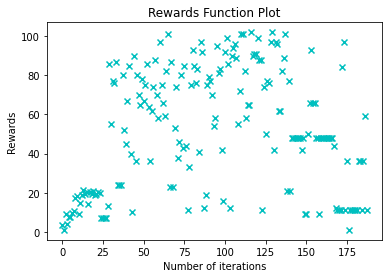

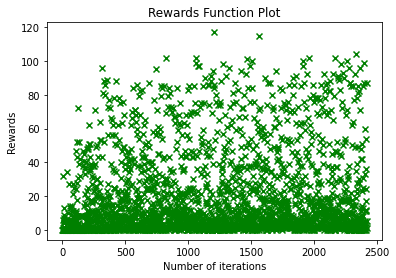

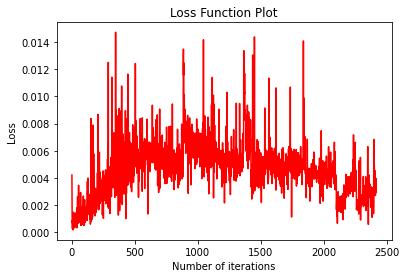

episode:  25


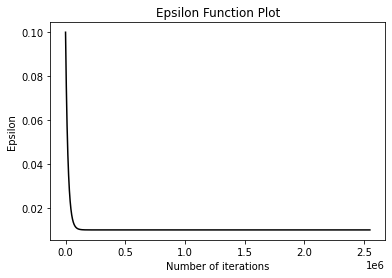

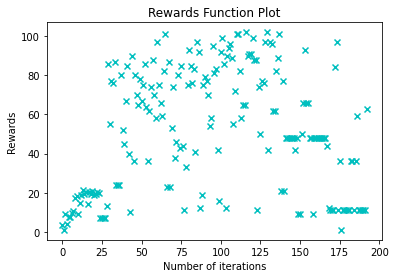

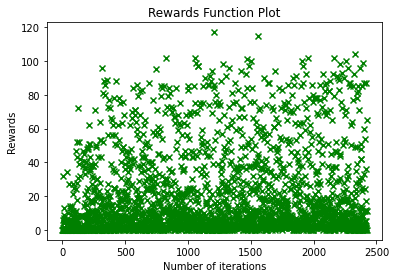

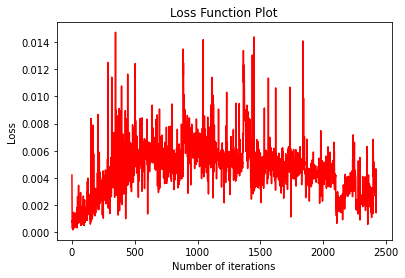

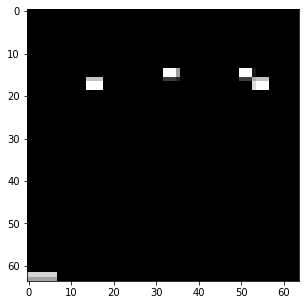

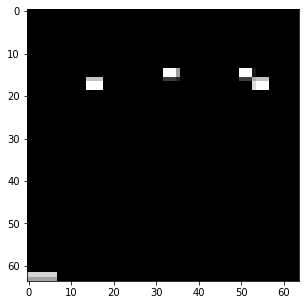

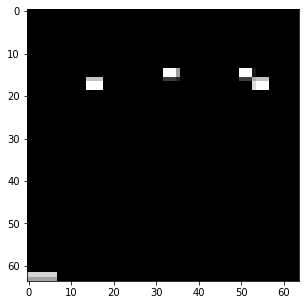

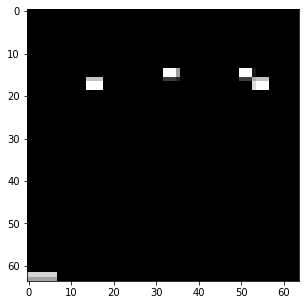

TypeError: ignored

In [257]:
def optimize_model(agent):
    global LEARNING_COUNTER
    losses = []
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # This converts batch-array of Transitions to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    # extract data from replay buffer
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = agent.policy_net(state_batch).gather(1, action_batch)
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
      # compute next step from target ploicy max(Q_target(s', a)) 
      next_state_values[non_final_mask] = agent.target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()

    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    #add loss to losses
    losses.append(loss)

    # Increment learn_counter (for dec_eps and replace_target_net)
    LEARNING_COUNTER += 1

    return losses

#############################
####### TRAINING LOOP #######
#############################

# fill the memory buffer with random samples
fill_memory_buffer()


for i_episode in range(EPISODES):

    # Initialize the environment and get it's state
    losses = []
    rewards = []
    
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    terminated = False
    cnt = 0
    score = 0

    # turn on visualization
    vis = False

    while not terminated:
        action = agent.sample_actions(state, sample_only=False)
        next_state, reward, terminated, truncated,  = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        rewards.append(reward)

        # # vis
        # if vis:
        #   plt.figure(figsize=[5,5])
        #   plt.imshow(next_state.reshape([-1, state_shape[2]])[:64,:], cmap='gray')
        #   plt.show()  
          
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state
        cnt += 1 
        score += reward

        if cnt % 4 == 0:
            loss = optimize_model(agent=agent)
            losses.append(loss)
        
    # update target network
    if i_episode > 0 and i_episode % UPDATE_FREQUENCY == 0:
        agent.update_target_network()

    # eval model
    if i_episode % 1 == 0: 
        mean_reward = evaluate(env, agent, n_games=1, greedy=True,vis=False, restart_env = True, end_game_verbose = False)
        rewards_eval.append(mean_reward)

        if mean_reward > current_max_reward:
          current_max_reward = mean_reward
          agent.save_current_model()

    # losses
    if not all(l is None for l in losses) :
      losses = [x for x in losses if x is not None]
      losses_np = torch.tensor(losses).detach().cpu().numpy()
      losses_epochs.append(losses_np.mean())

    # scoresc
    scores_epochs.append(score.cpu())
    scores_array = np.empty(len(scores_epochs), dtype=object)
    for i in range(len(scores_epochs)):
      scores_array[i] = np.array(scores_epochs[i])

    #plots
    if i_episode % 5 == 0:
      print("episode: ",i_episode) 
      plot_epsilon(epsilon_vals)
      plot_rewards(np.array(rewards_eval), 'c')
      plot_rewards(scores_array, 'g')
      plot_loss(np.array(losses_epochs))

print('Complete')
agent.update_target_network()
plot_epsilon(epsilon_vals)
plot_rewards(scores_array, 'g')
plot_rewards(np.array(rewards_eval), 'c')
plot_loss(np.array(losses_epochs))
plt.ioff()
plt.show()

# Plots

*Note- Unfortunatly the Colab crashes many times, this occured in our training and made it difficult to run a long training. To overcome this issue we separated our runs, thus the plots are seperated aswell. plots will be shown in 2 consecutive blocks according to their running order.*

## Plots explanation:

**Green plot** - reward as function of training episode

X-axis: training episodes

Y-axis: reward 

**Blue plot** - evaluated reward as function of training episodes

X-axis: training episodes in jumps of 20

Y-axis: reward 


**Red plot** - Loss as a function of training episodes

X-axis: training episodes

Y-axis: loss function

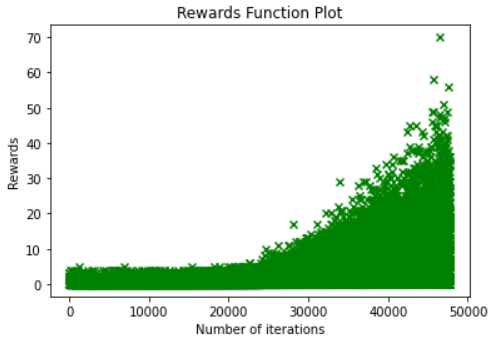

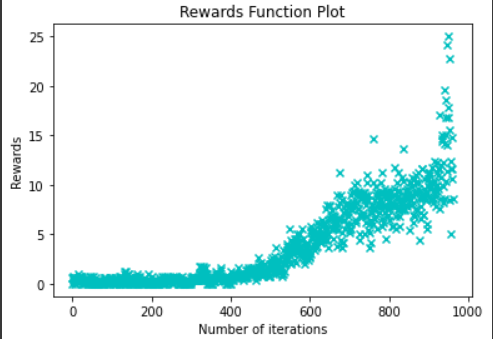


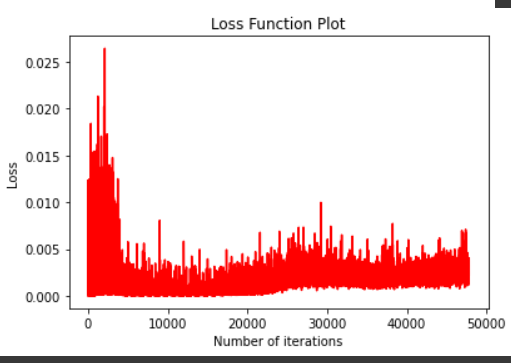

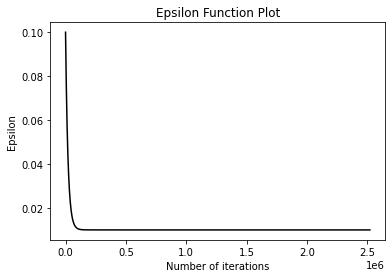

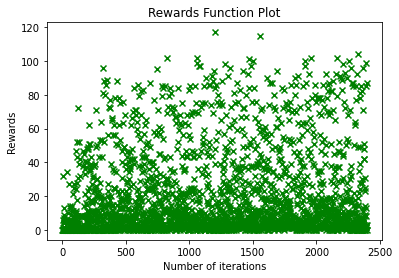

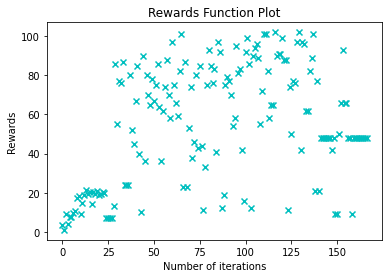

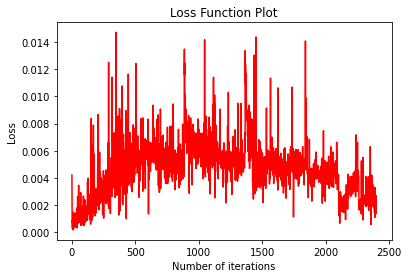

In [256]:
# plot the rest from this execution
plot_epsilon(epsilon_vals)
plot_rewards(scores_array, 'g')
plot_rewards(np.array(rewards_eval), 'c')
plot_loss(np.array(losses_epochs))
plt.ioff()
plt.show()

# Upload a model for inference

LOADING MODELS
game reward:  102.0
final state:


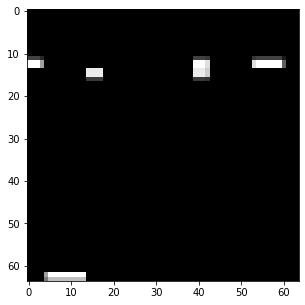

102.0


In [300]:
LOAD_MODEL_FOR_INFERENCE = False#@param ["False", "True"] {type:"raw"}
UPLOAD_FILES = False#@param ["False", "True"] {type:"raw"}
if LOAD_MODEL_FOR_INFERENCE is True:
  if UPLOAD_FILES:
    files.upload()
  agent = DQNAgent(n_actions, target_net=target_net, policy_net=policy_net)
  print("LOADING MODELS")
  target_state_dict = torch.load('policy_checkpoint (1).pth')
  agent.target_net.load_state_dict(target_state_dict)
  agent.policy_net.load_state_dict(target_state_dict)
  env = make_env()
  mean_reward = evaluate(env, agent, greedy=True, n_games=1, vis= False, restart_env = False, end_game_verbose=True)
  print(mean_reward)


## SAVE model

In [199]:
from google.colab import files
SAVE_MODEL = False #@param ["False", "True"] {type:"raw"}
DOWNLOAD_MODEL = False #@param ["False", "True"] {type:"raw"}
if SAVE_MODEL is True:
  torch.save(target_net.state_dict(), 'target_checkpoint.pth')
  torch.save(policy_net.state_dict(), 'policy_checkpoint.pth')
if DOWNLOAD_MODEL is True:
  files.download('target_checkpoint.pth')
  files.download('policy_checkpoint.pth')

## Random Agent

Here we implement a random agent to use in the 'evaluate' function, that runs the agent through multiple epsiodes. 

In [ ]:
class RandomAgent():
    def __init__(self, n_actions):
        self.n_actions = n_actions


    def get_qvalues(self, states):
        return np.random.normal(size=(1,self.n_actions,))

    def sample_actions(self, qvalues):
        return np.random.randint(self.n_actions, size=(1,)) 

## Video generation

game reward:  104.0
final state:


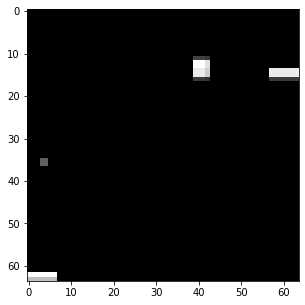

In [324]:
# run sessions
import gym.wrappers    
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

# Running the model with 1 live only for 1 game
#tmp_env = make_env()
with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    #env_monitor.reset()
    sessions = [evaluate(env_monitor, agent, n_games=1, greedy=True,vis=False, restart_env = False, end_game_verbose=True) for _ in range(1)] 
    
    


In [325]:
# show video

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices (if n_games>1)

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

## Assignment

Implement a DQN agent that contains:
1. A nerual network that predicts the q-values for a given observation.
2. An experience replay buffer where all transitions are added.
3. A target Q-network that is formed by periodically copying the weights of the main Q-nework.

You will also need to implement the training loop, and submit a figure showing the reward as a function of the training step, and a video showing an episode with the trained agent. 